In [19]:
import os
import sys
import argparse
import csv
import pandas as pd
import datetime as dt
import numpy as np
from pprint import pprint
from tqdm import tqdm
from pytictoc import TicToc
import traceback
from statistics import median
from statistics import mean
from statistics import mode
from statistics import stdev
from scipy import stats
from scipy import signal
import portion as P
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ******************************* User Settings *******************************
database = "/home/wmnlab/D/database/"
date = "2022-11-29"
devices = sorted([
    # "sm00",
    # "sm01",
    # "sm02",
    # "sm03",
    # "sm04",
    "sm05",
    "sm06",
    "sm07",
    "sm08",
    # "qc00",
    # "qc01",
    # "qc02",
    # "qc03",
])
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
            # If the list is None, it will not list as directories.
            # If the list is empty, it will list all directories in the current directory by default.
            # If the number of experiment times != the length of existing directories of list, it would trigger warning and skip the directory.
    # "tsync": (1, None),
    # "_Bandlock_Udp": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp": (4, ["#03", "#04", "#05", "#06"]),
    # "_Bandlock_Udp": (4, []),
    # "_Bandlock_Udp": (6, []),
    # "_Bandlock_Udp_B1_B3":  (1, ["#01"]),
    # "_Bandlock_Udp_B1_B3":  (4, []),
    "_Bandlock_Udp_B3_B28": (4, []),
    "_Bandlock_Udp_B28_B1": (4, []),
}

class Payload:
    LENGTH = 250              # (Bytes)
    TAG = "000425d401df5e76"  # 2 71828 3 1415926 (hex)            : 8-bytes
    OFS_TIME = (16, 24)       # epoch time of 'yyyy/mm/dd hh:mm:ss': 4-bytes
    OFS_USEC = (24, 32)       # microsecond (usec)                 : 4-bytes
    OFS_SEQN = (32, 40)       # sequence number (start from 1)     : 4-bytes
class ServerIP:
    PUBLIC = "140.112.20.183"  # 2F    
    PRIVATE = "192.168.1.251"  # 2F
    # PRIVATE = "192.168.1.248"  # 2F previous
    # PUBLIC = "140.112.17.209"  # 3F
    # PRIVATE = "192.168.1.108"  # 3F

DATA_RATE = 1000e3  # bits-per-second
PKT_RATE = DATA_RATE / Payload.LENGTH / 8  # packets-per-second
print("packet_rate (pps):", PKT_RATE, "\n")
# *****************************************************************************

packet_rate (pps): 500.0 



### handover type I

all@sm05
0.542 %
b3@sm06
0.396 %
b28@sm07
0.457 %
b3b28@sm08
0.29 %


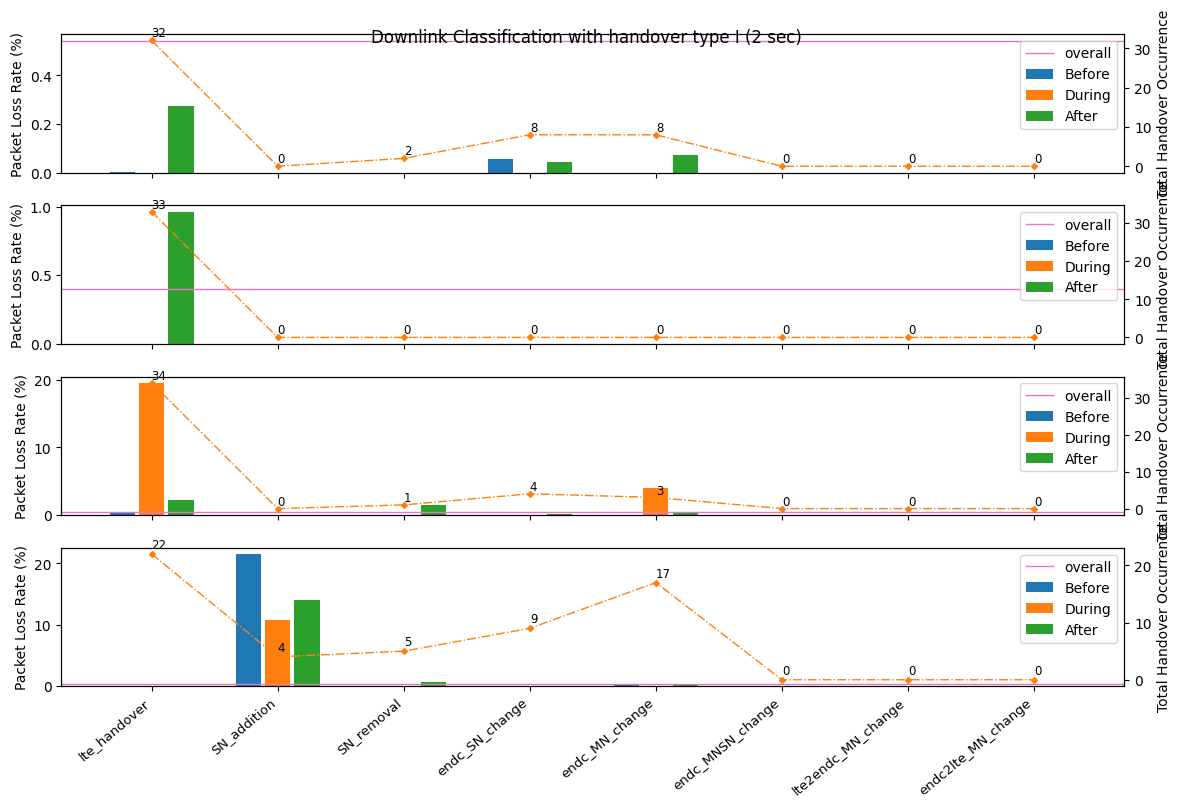

In [54]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type0.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

fig.suptitle("Downlink Classification with handover type I (2 sec)")
plt.show()

all@sm05
1.212 %
b3@sm06
0.939 %
b28@sm07
0.076 %
b3b28@sm08
0.391 %


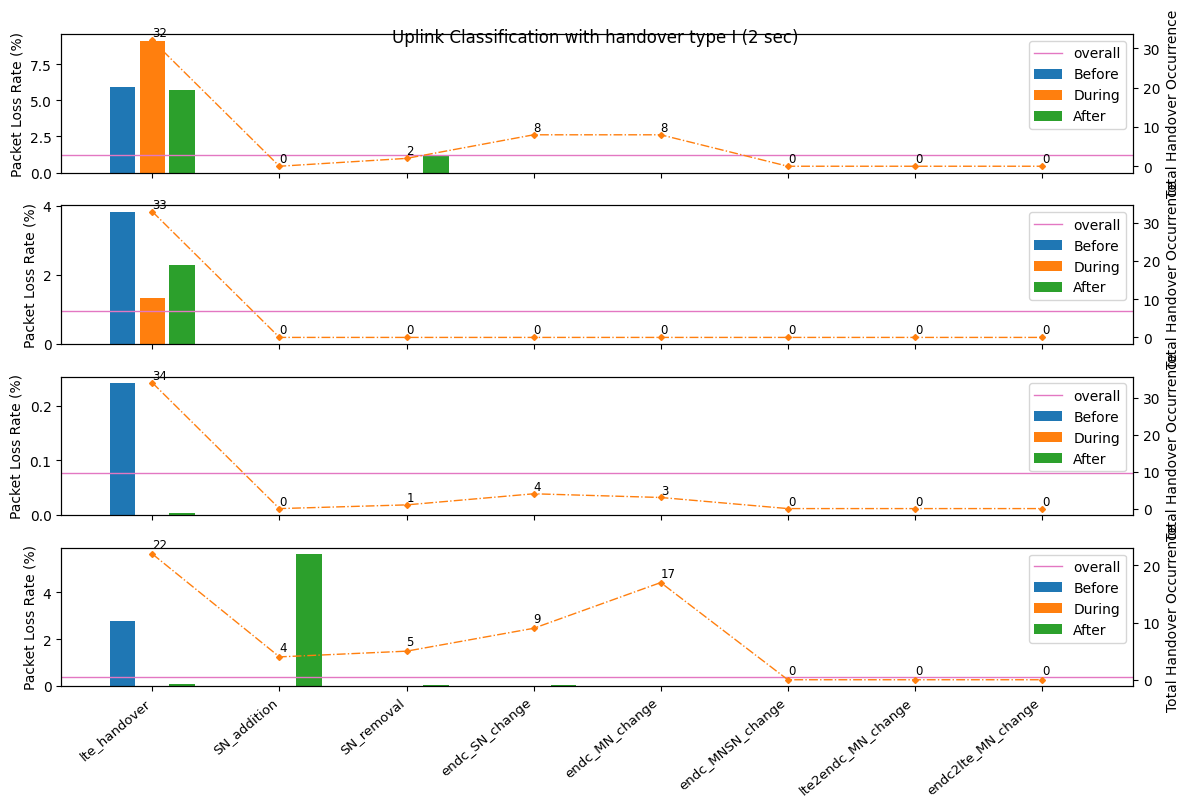

In [55]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "uplk_loss_classify_type0.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()
""""""
fig.suptitle("Uplink Classification with handover type I (2 sec)")
""""""
plt.show()

all@sm05
0.564 %
b28@sm06
0.589 %
b1@sm07
0.846 %
b1b28@sm08
0.952 %


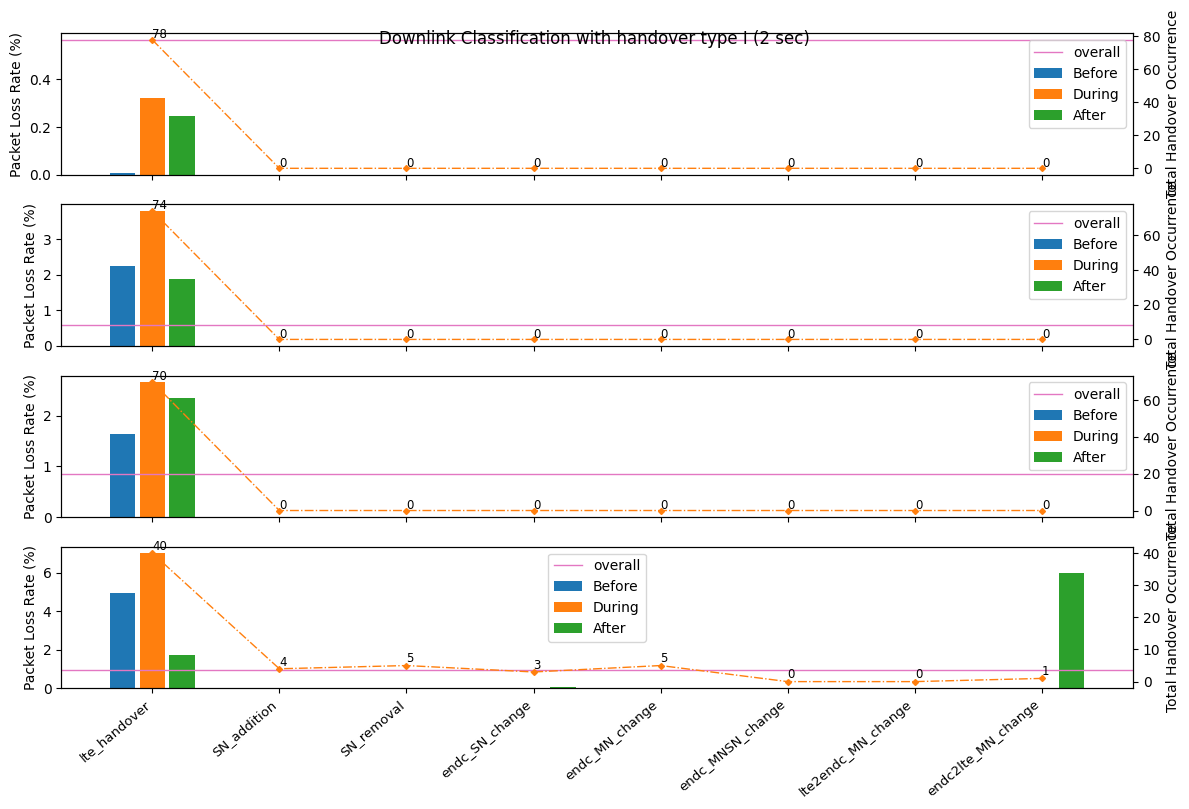

In [56]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b3", "b28", "b3b28"]
setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type0.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

fig.suptitle("Downlink Classification with handover type I (2 sec)")
plt.show()

all@sm05
0.224 %
b28@sm06
0.262 %
b1@sm07
6.592 %
b1b28@sm08
0.085 %


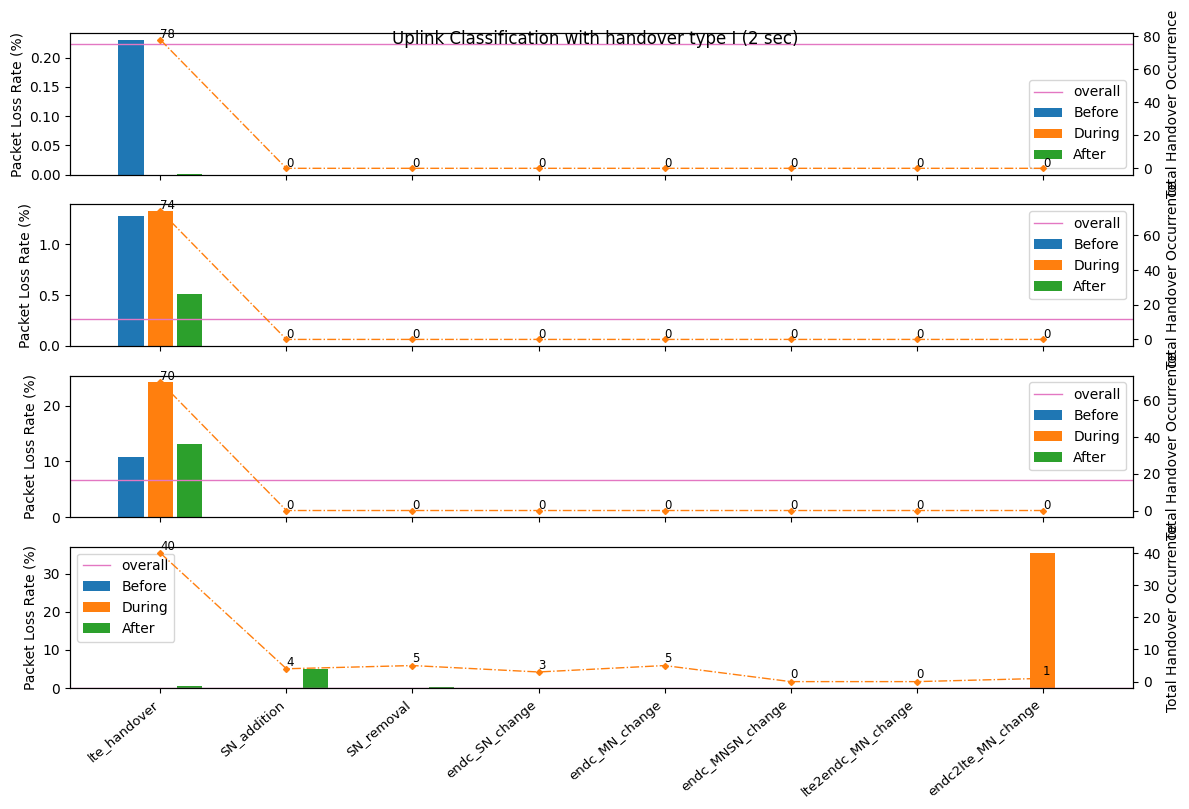

In [57]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b3", "b28", "b3b28"]
setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "uplk_loss_classify_type0.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()
""""""
fig.suptitle("Uplink Classification with handover type I (2 sec)")
""""""
plt.show()

### handover type II

all@sm05
0.542 %
b3@sm06
0.396 %
b28@sm07
0.457 %
b3b28@sm08
0.29 %


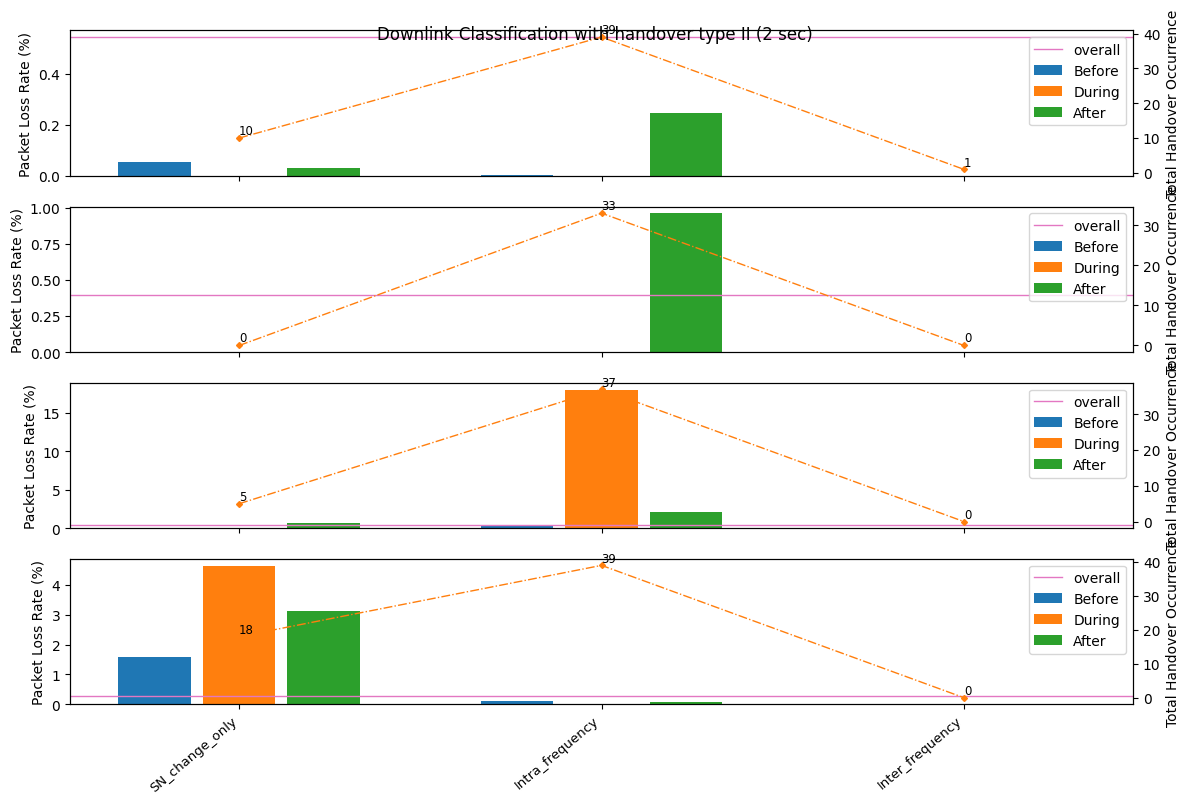

In [58]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_1

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type1.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

fig.suptitle("Downlink Classification with handover type II (2 sec)")
plt.show()

all@sm05
1.212 %
b3@sm06
0.939 %
b28@sm07
0.076 %
b3b28@sm08
0.391 %


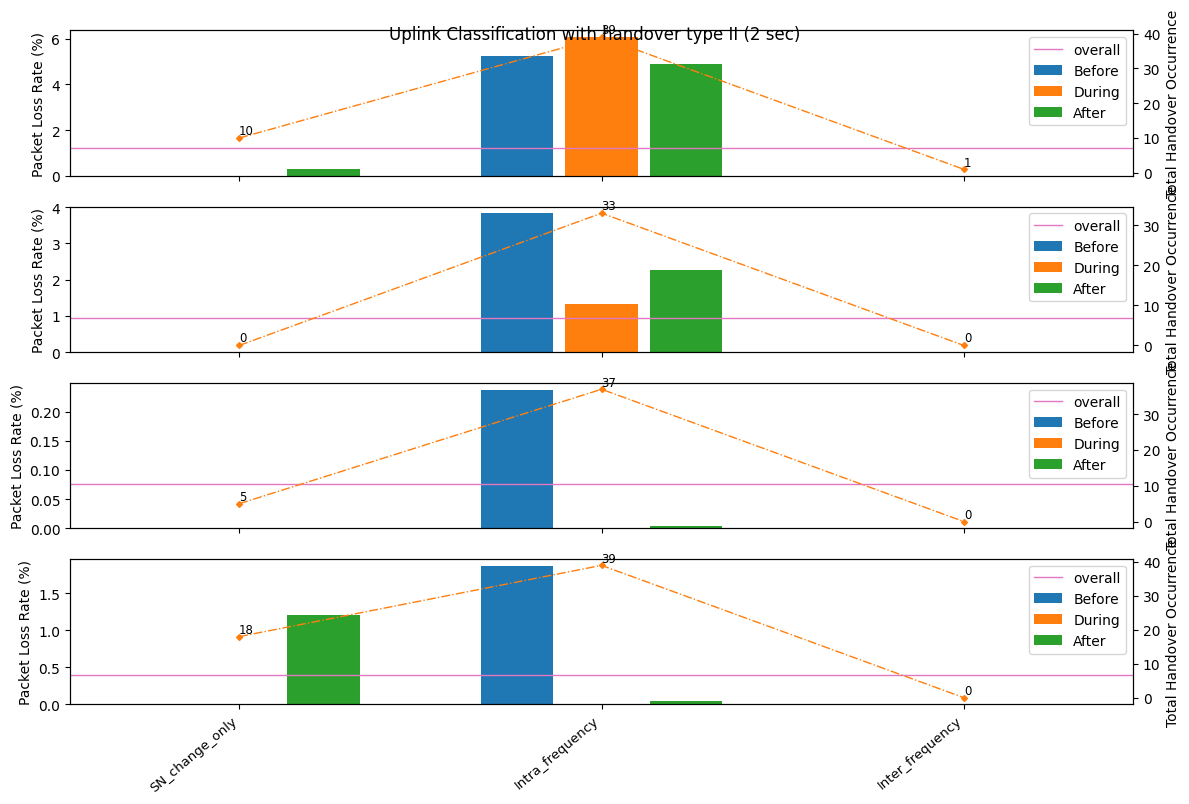

In [59]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_1

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "uplk_loss_classify_type1.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()
""""""
fig.suptitle("Uplink Classification with handover type II (2 sec)")
""""""
plt.show()

all@sm05
0.564 %
b28@sm06
0.589 %
b1@sm07
0.846 %
b1b28@sm08
0.952 %


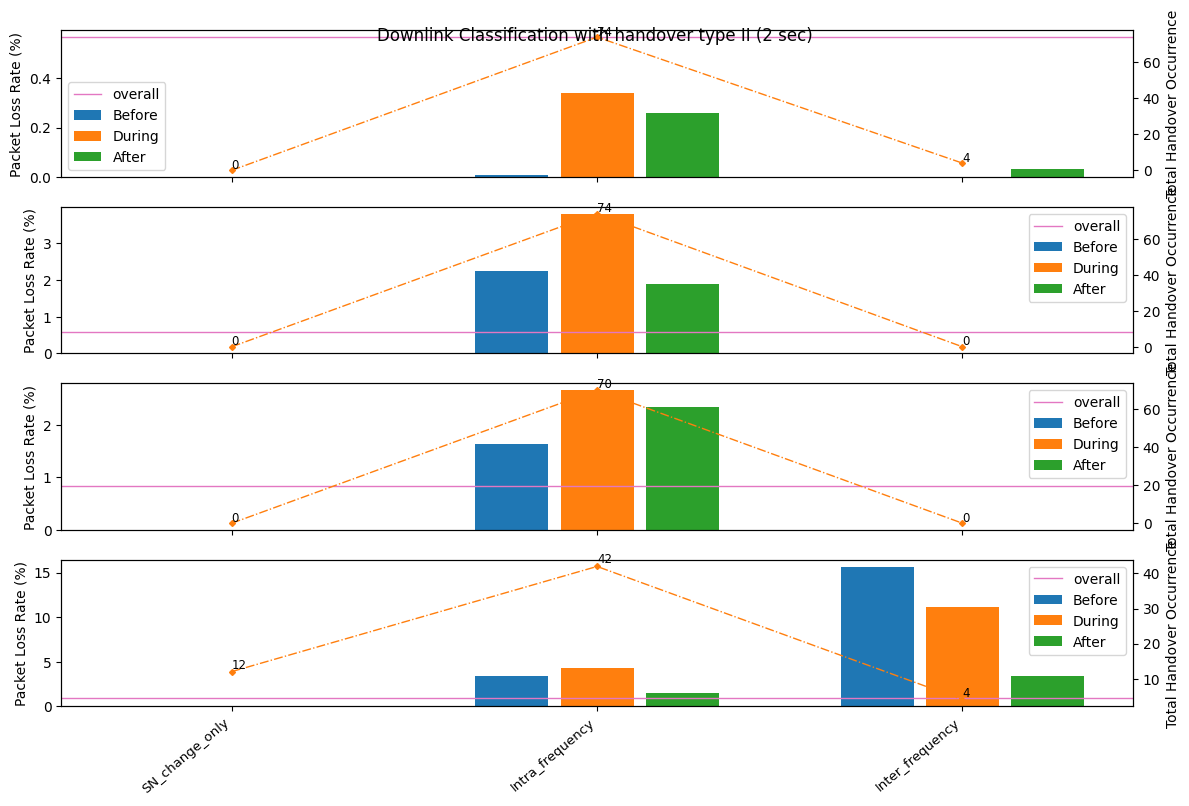

In [60]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b3", "b28", "b3b28"]
setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_1

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type1.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

fig.suptitle("Downlink Classification with handover type II (2 sec)")
plt.show()

all@sm05
0.224 %
b28@sm06
0.262 %
b1@sm07
6.592 %
b1b28@sm08
0.085 %


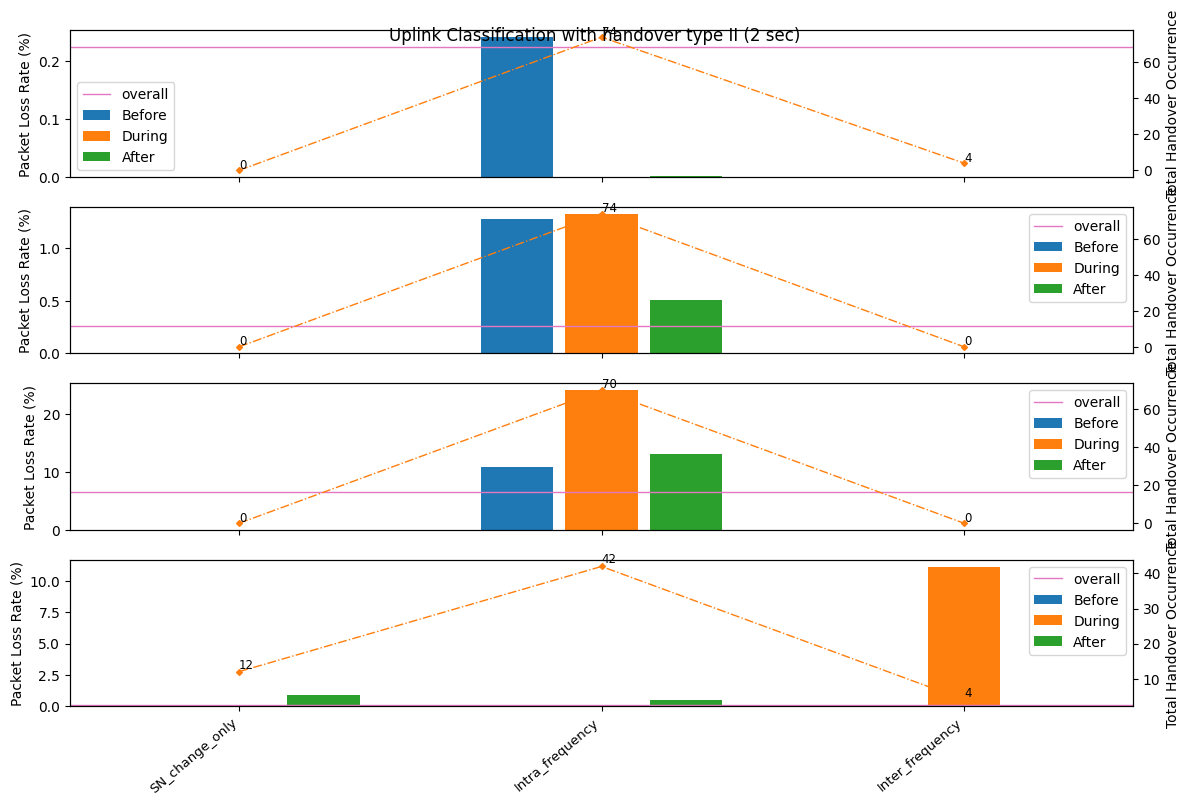

In [61]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b3", "b28", "b3b28"]
setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_1

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "uplk_loss_classify_type1.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()
""""""
fig.suptitle("Uplink Classification with handover type II (2 sec)")
""""""
plt.show()

### handover type III

all@sm05
0.542 %
b3@sm06
0.396 %
b28@sm07
0.457 %
b3b28@sm08
0.29 %


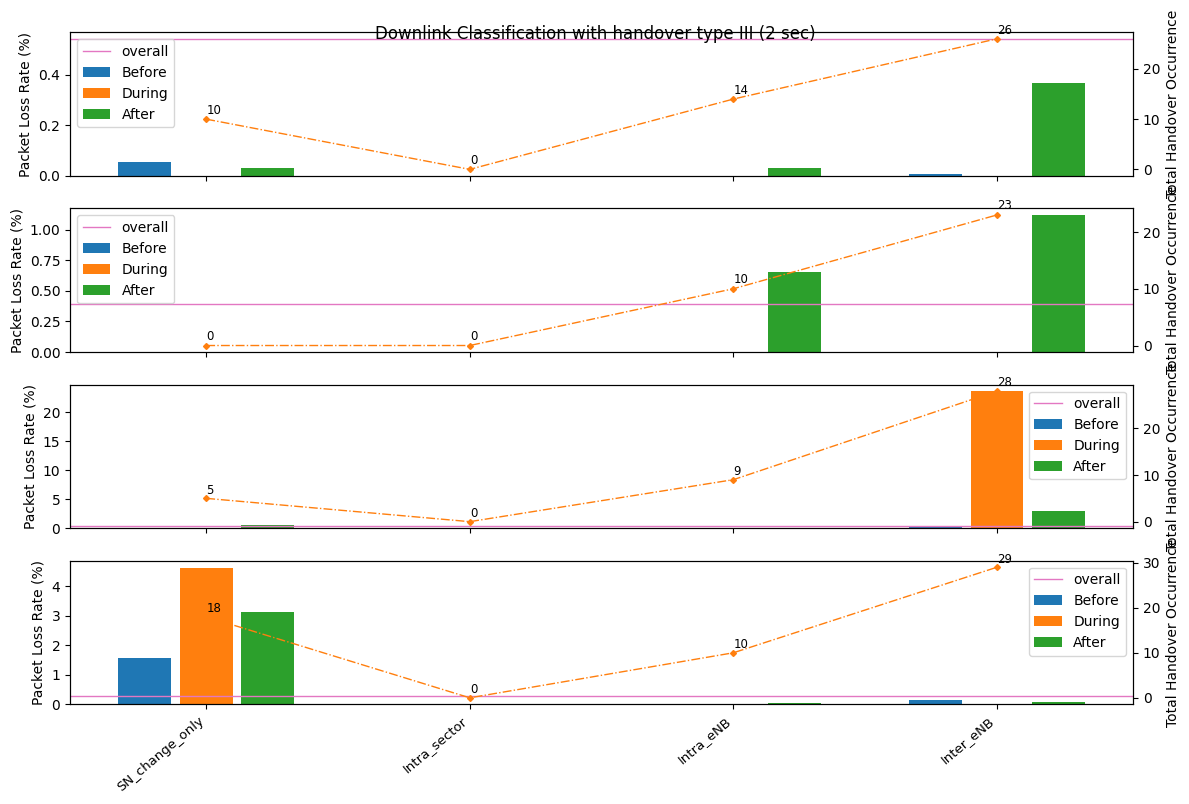

In [62]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_2

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type2.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

fig.suptitle("Downlink Classification with handover type III (2 sec)")
plt.show()

all@sm05
1.212 %
b3@sm06
0.939 %
b28@sm07
0.076 %
b3b28@sm08
0.391 %


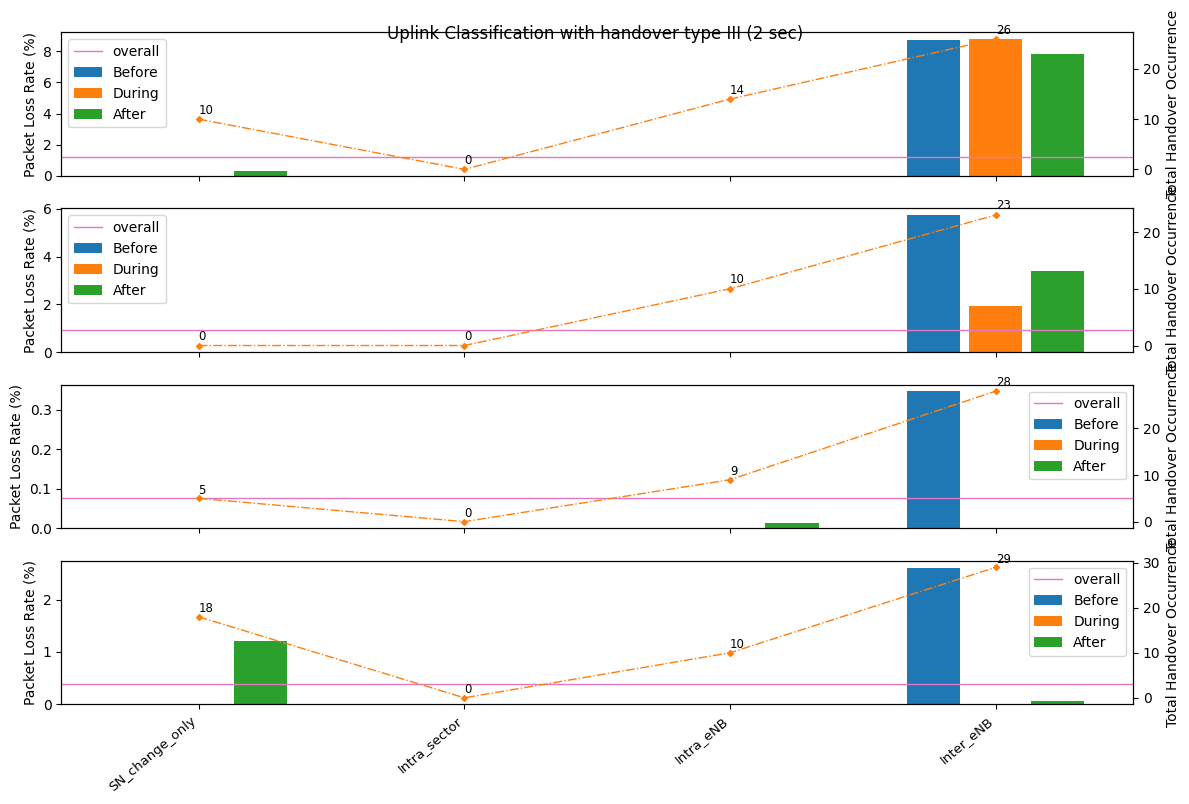

In [63]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_2

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "uplk_loss_classify_type2.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()
""""""
fig.suptitle("Uplink Classification with handover type III (2 sec)")
""""""
plt.show()

all@sm05
0.564 %
b28@sm06
0.589 %
b1@sm07
0.846 %
b1b28@sm08
0.952 %


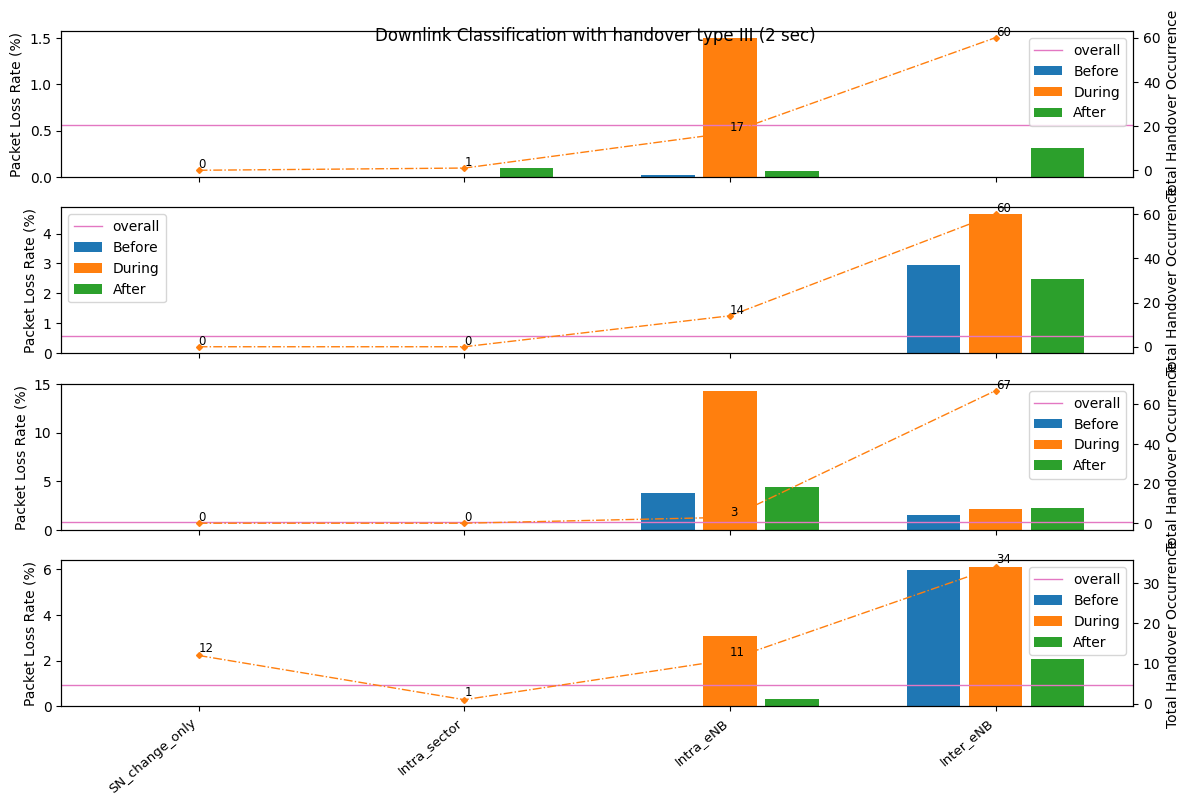

In [64]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b3", "b28", "b3b28"]
setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_2

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type2.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

fig.suptitle("Downlink Classification with handover type III (2 sec)")
plt.show()

all@sm05
0.224 %
b28@sm06
0.262 %
b1@sm07
6.592 %
b1b28@sm08
0.085 %


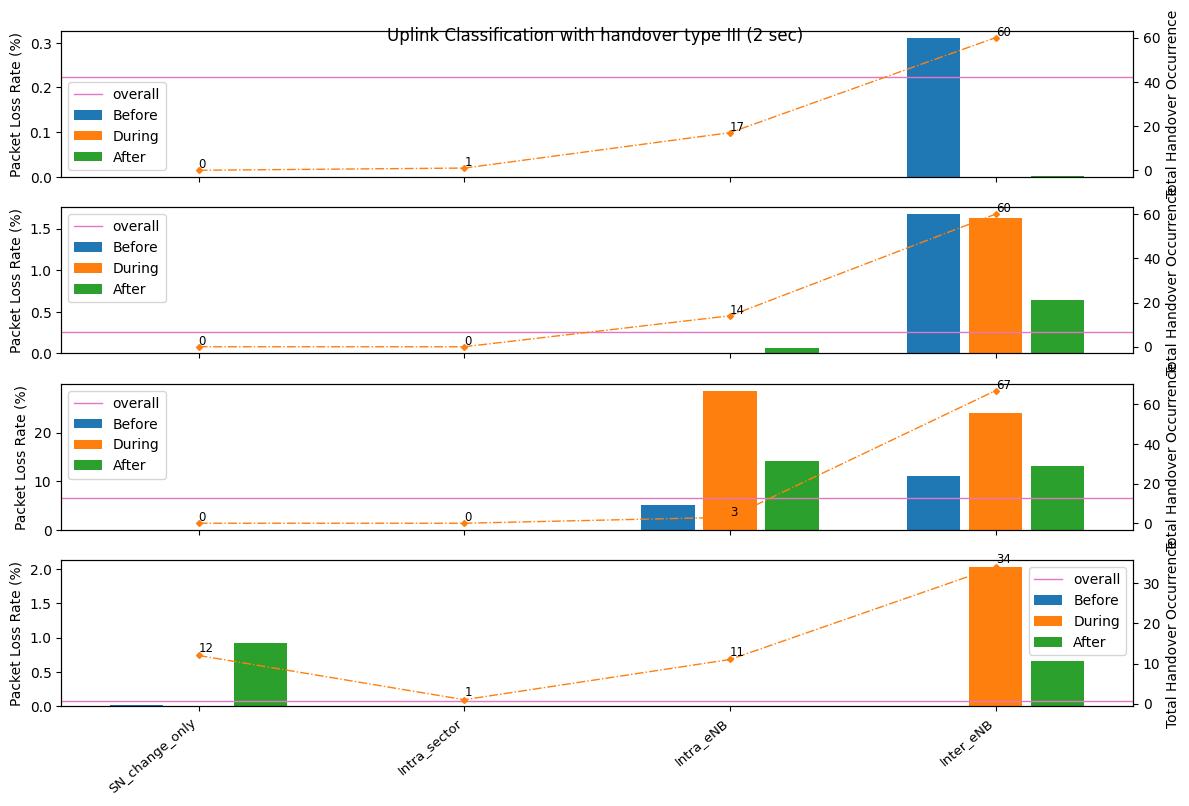

In [65]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b3", "b28", "b3b28"]
setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_2

# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[], []]
        for trace in traces:
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            """"""
            df = pd.read_csv(os.path.join(source_dir, "uplk_loss_classify_type2.csv"))
            """"""
            datarow = df[df["secs"] == 2].to_numpy()[0][1:]
            datarow = [item.split('@') for item in datarow]
            # print(datarow)
            occurrences = [int(item[0]) if item[0] != '-' else 0 for item in datarow]
            durations = [float(item[1]) for item in datarow]
            loss_num = [int(item[2]) for item in datarow]
            total_num = [int(item[3]) for item in datarow]
            loss_rate = [float(item[4]) for item in datarow]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, _type in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            total_loss[0].append(loss_num[-1])
            total_loss[1].append(total_num[-1])
        
        for i in range(len(handover_types)):
            event_occurrences[i] = sum(event_occurrences[i])
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
        total_loss = round(sum(total_loss[0]) / (sum(total_loss[1]) + 1e-9) * 100, 3)

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        print(total_loss, "%")

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss, c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Total Handover Occurrence')
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()
""""""
fig.suptitle("Uplink Classification with handover type III (2 sec)")
""""""
plt.show()